# System Identification Problem

In [1]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate("."); Pkg.instantiate();

  Activating project at `~/.julia/dev/RxInfer.jl/examples`


In [2]:
using RxInfer, Distributions, StableRNGs, Plots

## Two merged signals 

For this example we are going to attempt to run Bayesian inference and decouple two random-walk signals, which were combined into one with some deterministic function `f`. We shall not have an access to the real values of these signals, but only to their combination. First, we greate the `generate_data` function that accepts `f` as an argument:

In [3]:
function generate_data(f, n; seed = 123, x_i_min = -20.0, w_i_min = 20.0, noise = 20.0, real_x_τ = 0.1, real_w_τ = 1.0)

    rng = StableRNG(seed)

    real_x = Vector{Float64}(undef, n)
    real_w = Vector{Float64}(undef, n)
    real_y = Vector{Float64}(undef, n)

    for i in 1:n
        real_x[i] = rand(rng, Normal(x_i_min, sqrt(1.0 / real_x_τ)))
        real_w[i] = rand(rng, Normal(w_i_min, sqrt(1.0 / real_w_τ)))
        real_y[i] = rand(rng, Normal(f(real_x[i], real_w[i]), sqrt(noise)))

        x_i_min = real_x[i]
        w_i_min = real_w[i]
    end
    
    return real_x, real_w, real_y
end

generate_data (generic function with 1 method)

The function returns `x`, `w` signals for later test (we are not going to use it for the inference) and their combined version `y` (we are going to use it as our observations during the inference). We also assume that `y` is corrupted with noise.

### y = x + w

In our first example, we are going to use a simple `+` as the function `f`. In general, it is impossible to decouple `x` and `w` without strong priors, but we can try and see how good an inference can be. `+` also has a special meaning in the Bayesian inference (convolution of pdf's of two random variables) and `RxInfer` treats it specially with many precomputed analytical rules, which may make the inference task easier. First, lets create a test dataset:

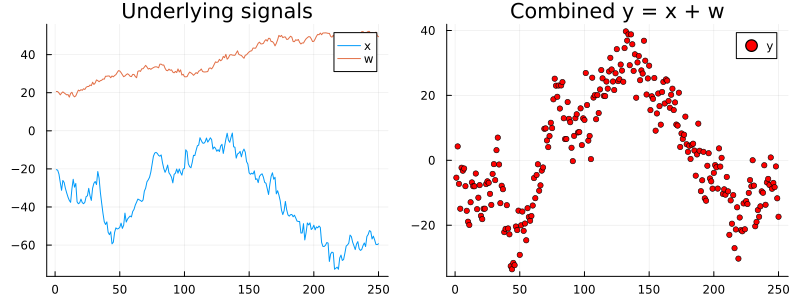

In [4]:
n = 250
real_x, real_w, real_y = generate_data(+, n);

pl = plot(title = "Underlying signals")
pl = plot!(pl, real_x, label = "x")
pl = plot!(pl, real_w, label = "w")

pr = plot(title = "Combined y = x + w")
pr = scatter!(pr, real_y, ms = 3, color = :red, label = "y")

plot(pl, pr, size = (800, 300))

To run inference, we need to create a probabilistic model: our beliefs about how our data could have been generated. For this we can use the `@model` macro from the `RxInfer` package:

In [5]:
@model function identification_problem(f, n, m_x_0, τ_x_0, a_x, b_x, m_w_0, τ_w_0, a_w, b_w, a_y, b_y)
    
    x0 ~ Normal(mean = m_x_0, precision = τ_x_0)
    τ_x ~ Gamma(shape = a_x, rate = b_x)
    w0 ~ Normal(mean = m_w_0, precision = τ_w_0)
    τ_w ~ Gamma(shape = a_w, rate = b_w)
    τ_y ~ Gamma(shape = a_y, rate = b_y)
    
    x = randomvar(n)
    w = randomvar(n)
    s = randomvar(n)
    y = datavar(Float64, n)
    
    x_i_min = x0
    w_i_min = w0
    
    for i in 1:n
        x[i] ~ Normal(mean = x_i_min, precision = τ_x)
        w[i] ~ Normal(mean = w_i_min, precision = τ_w)
        s[i] ~ f(x[i], w[i])
        y[i] ~ Normal(mean = s[i], precision = τ_y)
        
        x_i_min = x[i]
        w_i_min = w[i]
    end
    
end

`RxInfer` runs Bayesian inference as variational optimisation procedure between real solution and its variational proxy `q`. In our model specification we assumed noise components to be unknown, thus, we need to enforce structured mean-field assumption for the variational family of distributions `q`. That inevitable reduces the accuracy of the result, but makes the task easier and allows for fast and analytical message-passing based variational inference:

In [6]:
constraints = @constraints begin 
    q(x0, w0, x, w, τ_x, τ_w, τ_y, s) = q(x, x0, w, w0, s)q(τ_w)q(τ_x)q(τ_y)
end

Constraints:
  marginals form:
  messages form:
  factorisation:
    q(x0, w0, x, w, τ_x, τ_w, τ_y, s) = q(x, x0, w, w0, s)q(τ_w)q(τ_x)q(τ_y)
Options:
  warn = true


The next step is to assign priors, initialise needed messages and marginals and call the `inference` function:

In [7]:
m_x_0, τ_x_0 = -20.0, 1.0
m_w_0, τ_w_0 = 20.0, 1.0

# We set relatively strong priors for random walk noise components
# and sort of vague prior for the noise of the observations
a_x, b_x = 0.01, 0.01var(real_x)
a_w, b_w = 0.01, 0.01var(real_w)
a_y, b_y = 1.0, 1.0

# We set relatively strong priors for messges
xinit = map(r -> NormalMeanPrecision(r, τ_x_0), reverse(range(-60, -20, length = n)))
winit = map(r -> NormalMeanPrecision(r, τ_w_0), range(20, 60, length = n))

imessages = (x = xinit, w = winit)
imarginals = (τ_x = GammaShapeRate(a_x, b_x), τ_w = GammaShapeRate(a_w, b_w), τ_y = GammaShapeRate(a_y, b_y))

result = inference(
    model = identification_problem(+, n, m_x_0, τ_x_0, a_x, b_x, m_w_0, τ_w_0, a_w, b_w, a_y, b_y),
    data  = (y = real_y,), 
    options = (limit_stack_depth = 500, ), 
    constraints = constraints, 
    initmessages = imessages, 
    initmarginals = imarginals, 
    iterations = 50
)

Inference results:
  Posteriors       | available for (w0, w, x0, s, τ_x, τ_w, τ_y, x)


Let's examine our inference results:

In [8]:
τ_x_marginals = result.posteriors[:τ_x]
τ_w_marginals = result.posteriors[:τ_w]
τ_y_marginals = result.posteriors[:τ_y]

smarginals = result.posteriors[:s]
xmarginals = result.posteriors[:x]
wmarginals = result.posteriors[:w];

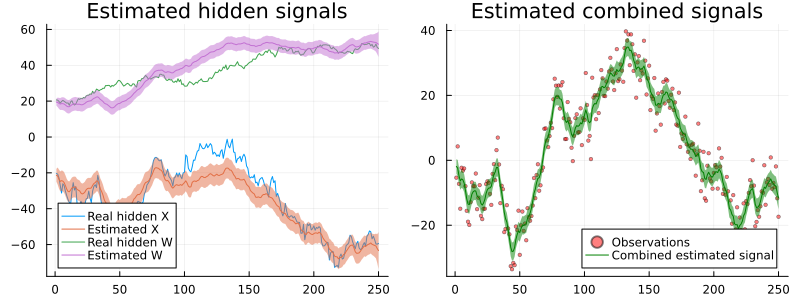

In [9]:
px1 = plot(legend = :bottomleft, title = "Estimated hidden signals")
px2 = plot(legend = :bottomright, title = "Estimated combined signals")

px1 = plot!(px1, real_x, label = "Real hidden X")
px1 = plot!(px1, mean.(xmarginals[end]), ribbon = var.(xmarginals[end]), label = "Estimated X")

px1 = plot!(px1, real_w, label = "Real hidden W")
px1 = plot!(px1, mean.(wmarginals[end]), ribbon = var.(wmarginals[end]), label = "Estimated W")

px2 = scatter!(px2, real_y, label = "Observations", ms = 2, alpha = 0.5, color = :red)
px2 = plot!(px2, mean.(smarginals[end]), ribbon = std.(smarginals[end]), label = "Combined estimated signal", color = :green)

plot(px1, px2, size = (800, 300))

The inference results are not so bad, even though `RxInfer` missed the correct values of the signals between `100` and `150`.

### y = min(x, w)

In this example we use a slightly more complex function, for which `RxInfer` also does not have precomputed analytical message update rules. We are going to attempt to run Bayesian inference with `min` as a combination function. Note, however, that directly using `min` may cause problems for the built-in approximation methods as it has zero partial derviates with respect to all but one of the variables. We generate data with the `min` function directly however:

In [10]:
# Smoothed version of `min` without zero-ed derivatives
function smooth_min(x, y)    
    if x < y
        return x + 1e-4 * y
    else
        return y + 1e-4 * x
    end
end

smooth_min (generic function with 1 method)

`RxInfer` does support arbitrary nonlinear functions, but it requires an explicit approximation method specification. That can be achieved with the built-in `@meta` macro:

In [11]:
min_meta = @meta begin 
    # In this example we are going to use a simple `Linearization` method
    smooth_min() -> Linearization()
end

Meta specification:
  smooth_min() -> Linearization()
Options:
  warn = true

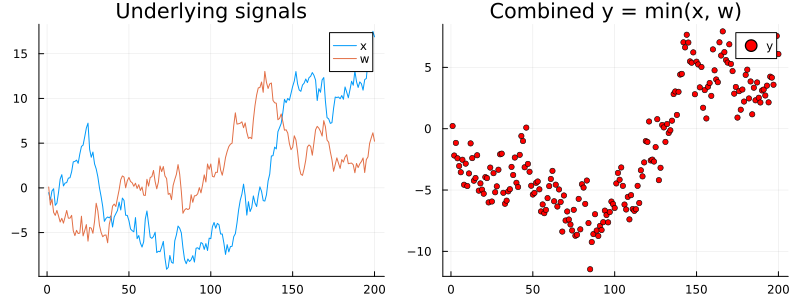

In [12]:
n = 200
min_real_x, min_real_w, min_real_y = generate_data(min, n, seed = 1, x_i_min = 0.0, w_i_min = 0.0, noise = 1.0, real_x_τ = 1.0, real_w_τ = 1.0);

pl = plot(title = "Underlying signals")
pl = plot!(pl, min_real_x, label = "x")
pl = plot!(pl, min_real_w, label = "w")

pr = plot(title = "Combined y = min(x, w)")
pr = scatter!(pr, min_real_y, ms = 3, color = :red, label = "y")

plot(pl, pr, size = (800, 300))

In [13]:
min_m_x_0, min_τ_x_0 = -1.0, 1.0
min_m_w_0, min_τ_w_0 = 1.0, 1.0

min_a_x, min_b_x = 1.0, 1.0
min_a_w, min_b_w = 1.0, 1.0
min_a_y, min_b_y = 1.0, 1.0

min_imessages = (x = NormalMeanPrecision(min_m_x_0, min_τ_x_0), w = NormalMeanPrecision(min_m_w_0, min_τ_w_0))
min_imarginals = (τ_x = GammaShapeRate(min_a_x, min_b_x), τ_w = GammaShapeRate(min_a_w, min_b_w), τ_y = GammaShapeRate(min_a_y, min_b_y))

min_result = inference(
    model = identification_problem(smooth_min, n, min_m_x_0, min_τ_x_0, min_a_x, min_b_x, min_m_w_0, min_τ_w_0, min_a_w, min_b_w, min_a_y, min_b_y),
    data  = (y = min_real_y,), 
    meta = min_meta,
    options = (limit_stack_depth = 500, ), 
    constraints = constraints, 
    initmessages = min_imessages, 
    initmarginals = min_imarginals, 
    iterations = 100
)

Inference results:
  Posteriors       | available for (w0, w, x0, s, τ_x, τ_w, τ_y, x)


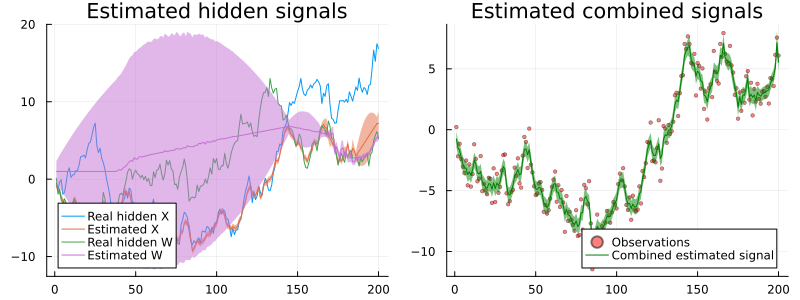

In [14]:
min_τ_x_marginals = min_result.posteriors[:τ_x]
min_τ_w_marginals = min_result.posteriors[:τ_w]
min_τ_y_marginals = min_result.posteriors[:τ_y]

min_smarginals = min_result.posteriors[:s]
min_xmarginals = min_result.posteriors[:x]
min_wmarginals = min_result.posteriors[:w]

px1 = plot(legend = :bottomleft, title = "Estimated hidden signals")
px2 = plot(legend = :bottomright, title = "Estimated combined signals")

px1 = plot!(px1, min_real_x, label = "Real hidden X")
px1 = plot!(px1, mean.(min_xmarginals[end]), ribbon = var.(min_xmarginals[end]), label = "Estimated X")

px1 = plot!(px1, min_real_w, label = "Real hidden W")
px1 = plot!(px1, mean.(min_wmarginals[end]), ribbon = var.(min_wmarginals[end]), label = "Estimated W")

px2 = scatter!(px2, min_real_y, label = "Observations", ms = 2, alpha = 0.5, color = :red)
px2 = plot!(px2, mean.(min_smarginals[end]), ribbon = std.(min_smarginals[end]), label = "Combined estimated signal", color = :green)

plot(px1, px2, size = (800, 300))

As we can see inference with the `min` function is significantly harder. Even though the combined signal has been inferred with high precision the underlying `x` and `w` signals are barely inferred. This may be expected, since the `min` function essentially destroy the information about one of the signals, thus, making it impossible to decouple two seemingly identical random walk signals. The only one inferred signal is the one which is lower and we have no inference information about the signal which is above. It might be possible to infer the states, however, with more informative priors and structural information about two different signals (e.g. if these are not random walks). 

### Online (filtering) identification: y = min(x, w)

Another way to approach to this problem is to use online (filtering) inference procedure from `RxInfer`, but for that we also need to modify our model specification a bit:

In [15]:
@model function rx_identification(f)
    
    # We are going to continuosly update our priors
    # based on new posteriors
    m_x_0 = datavar(Float64) 
    τ_x_0 = datavar(Float64)
    m_w_0 = datavar(Float64) 
    τ_w_0 = datavar(Float64)
    a_x   = datavar(Float64) 
    b_x   = datavar(Float64)
    a_y   = datavar(Float64) 
    b_y   = datavar(Float64)
    a_w   =  datavar(Float64) 
    b_w   = datavar(Float64)
    s     = randomvar()
    y     = datavar(Float64)
    
    x0 ~ Normal(mean = m_x_0, precision = τ_x_0)
    τ_x ~ Gamma(shape = a_x, rate = b_x)
    w0 ~ Normal(mean = m_w_0, precision = τ_w_0)
    τ_w ~ Gamma(shape = a_w, rate = b_w)
    τ_y ~ Gamma(shape = a_y, rate = b_y)
    
    x ~ Normal(mean = x0, precision = τ_x)
    w ~ Normal(mean = w0, precision = τ_w)

    s ~ f(x, w)
    y ~ Normal(mean = s, precision = τ_y)
    
end

We impose structured mean-field assumption for this model as well:

In [16]:
rx_constraints = @constraints begin 
    q(x0, x, w0, w, τ_x, τ_w, τ_y, s) = q(x0, x)q(w, w0)q(τ_w)q(τ_x)q(s)q(τ_y)
end

Constraints:
  marginals form:
  messages form:
  factorisation:
    q(x0, x, w0, w, τ_x, τ_w, τ_y, s) = q(x0, x)q(w, w0)q(τ_w)q(τ_x)q(s)q(τ_y)
Options:
  warn = true


Online inference in the `RxInfer` supports the `@autoupdates` specification, which tells inference procedure how to update priors based on new computed posteriors:

In [17]:
autoupdates = @autoupdates begin 
    m_x_0, τ_x_0 = mean_precision(q(x))
    m_w_0, τ_w_0 = mean_precision(q(w))
    a_x = shape(q(τ_x)) 
    b_x = rate(q(τ_x))
    a_y = shape(q(τ_y))
    b_y = rate(q(τ_y))
    a_w = shape(q(τ_w)) 
    b_w = rate(q(τ_w))
end

(m_x_0,τ_x_0 = mean_precision(q(x)), m_w_0,τ_w_0 = mean_precision(q(w)), a_x = shape(q(τ_x)), b_x = rate(q(τ_x)), a_y = shape(q(τ_y)), b_y = rate(q(τ_y)), a_w = shape(q(τ_w)), b_w = rate(q(τ_w)))

As previously we need to define the `@meta` structure that specifies the approximation method for the nonlinear function `rxmin` (`f` in the model specification):

In [18]:
rx_meta = @meta begin 
    smooth_min() -> Linearization()
end

Meta specification:
  smooth_min() -> Linearization()
Options:
  warn = true

Next step is to generate our dataset and to run the actual inference procedure! For that we use the `rxinference` function, which has a similar API as the `inference` function:

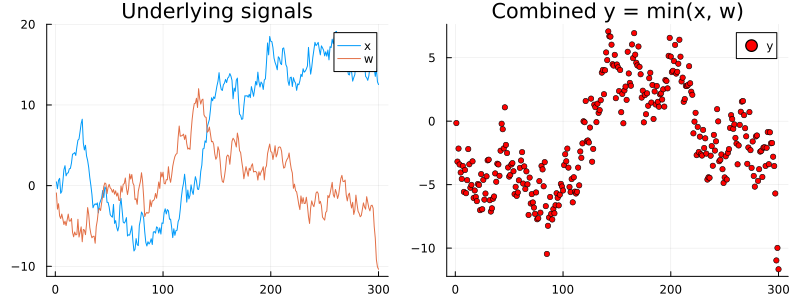

In [19]:
n = 300
rx_real_x, rx_real_w, rx_real_y = generate_data(min, n, seed = 1, x_i_min = 1.0, w_i_min = -1.0, noise = 1.0, real_x_τ = 1.0, real_w_τ = 1.0);

pl = plot(title = "Underlying signals")
pl = plot!(pl, rx_real_x, label = "x")
pl = plot!(pl, rx_real_w, label = "w")

pr = plot(title = "Combined y = min(x, w)")
pr = scatter!(pr, rx_real_y, ms = 3, color = :red, label = "y")

plot(pl, pr, size = (800, 300))

In [20]:
engine = rxinference(
    model         = rx_identification(smooth_min),
    constraints   = rx_constraints,
    data          = (y = rx_real_y,),
    autoupdates   = autoupdates,
    meta          = rx_meta,
    returnvars    = (:x, :w, :τ_x, :τ_w, :τ_y, :s),
    keephistory   = 1000,
    historyvars   =  KeepLast(),
    initmarginals = (w = NormalMeanVariance(-2.0, 1.0), x = NormalMeanVariance(2.0, 1.0), τ_x = GammaShapeRate(1.0, 1.0), τ_w = GammaShapeRate(1.0, 1.0), τ_y = GammaShapeRate(1.0, 20.0)),
    iterations    = 10,
    free_energy = true, 
    free_energy_diagnostics = nothing,
    autostart     = true,
)

RxInferenceEngine:
  Posteriors stream    | enabled for (w, s, τ_x, τ_w, τ_y, x)
  Free Energy stream   | enabled
  Posteriors history   | available for (x, w, x0, s, τ_x, τ_w, τ_y, w0)
  Free Energy history  | available
  Enabled events       | [  ]

In [21]:
rx_smarginals = engine.history[:s]
rx_xmarginals = engine.history[:x]
rx_wmarginals = engine.history[:w];

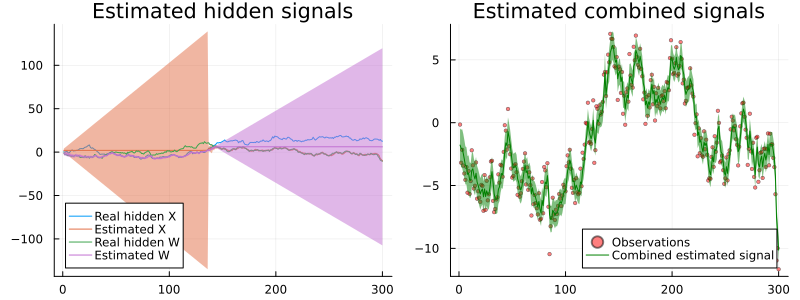

In [22]:
px1 = plot(legend = :bottomleft, title = "Estimated hidden signals")
px2 = plot(legend = :bottomright, title = "Estimated combined signals")

px1 = plot!(px1, rx_real_x, label = "Real hidden X")
px1 = plot!(px1, mean.(rx_xmarginals), ribbon = var.(rx_xmarginals), label = "Estimated X")

px1 = plot!(px1, rx_real_w, label = "Real hidden W")
px1 = plot!(px1, mean.(rx_wmarginals), ribbon = var.(rx_wmarginals), label = "Estimated W")

px2 = scatter!(px2, rx_real_y, label = "Observations", ms = 2, alpha = 0.5, color = :red)
px2 = plot!(px2, mean.(rx_smarginals), ribbon = std.(rx_smarginals), label = "Combined estimated signal", color = :green)

plot(px1, px2, size = (800, 300))

The results are quite similar to the smoothing case and, as we can see, one of the random walk is again in the "disabled" state, does not infer anything and simply increases its variance (which is expected for the random walk).